In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ghibli-movies-pictures/Ghibli_movie_dataset/The Tale of Princess Kaguya/408fe9ce-73e4-4187-b8f5-e4bd65de542c.png
/kaggle/input/ghibli-movies-pictures/Ghibli_movie_dataset/The Tale of Princess Kaguya/bff1b047-3b04-447a-afcb-d826e702ce1c.jpg
/kaggle/input/ghibli-movies-pictures/Ghibli_movie_dataset/The Tale of Princess Kaguya/6b53db8d-94fa-4c3b-afbe-96aea05373ec.jpg
/kaggle/input/ghibli-movies-pictures/Ghibli_movie_dataset/The Tale of Princess Kaguya/ab848133-bfc5-4b57-b830-31f22a078403.jpg
/kaggle/input/ghibli-movies-pictures/Ghibli_movie_dataset/The Tale of Princess Kaguya/438f1829-cfe9-4c8f-b5eb-175d24355d87.jpg
/kaggle/input/ghibli-movies-pictures/Ghibli_movie_dataset/The Tale of Princess Kaguya/a2b000c2-6267-4187-a008-2a284fcc8e1c.jpg
/kaggle/input/ghibli-movies-pictures/Ghibli_movie_dataset/The Tale of Princess Kaguya/ea824aed-0184-46de-a499-1ad28642136d.jpg
/kaggle/input/ghibli-movies-pictures/Ghibli_movie_dataset/The Tale of Princess Kaguya/b0b75eb4-d26d-4635-b3f7-7

In [8]:
import shutil
from pathlib import Path

# Paths to your datasets
artist_dataset_path = Path("/kaggle/input/best-artworks-of-all-time/images/images")
ghibli_dataset_path = Path("/kaggle/input/ghibli-movies-pictures/Ghibli_movie_dataset")
pixel_dataset_path = Path("/kaggle/input/pixel-art/images/images")

# Path to the combined dataset directory
combined_dataset_path = Path("/kaggle/working/combined_dataset")

# Create combined dataset folder if it doesn't exist
combined_dataset_path.mkdir(parents=True, exist_ok=True)

# Define the target subfolders for each dataset
artist_target_folder = combined_dataset_path / "Artist"
ghibli_target_folder = combined_dataset_path / "Ghibli"
pixel_target_folder = combined_dataset_path / "PixelArt"

# Create target subfolders if they don't exist
artist_target_folder.mkdir(parents=True, exist_ok=True)
ghibli_target_folder.mkdir(parents=True, exist_ok=True)
pixel_target_folder.mkdir(parents=True, exist_ok=True)

# Function to copy images from source to target directory
def copy_images(source_dir, target_dir):
    for folder in source_dir.iterdir():
        if folder.is_dir():
            target_subfolder = target_dir / folder.name
            target_subfolder.mkdir(parents=True, exist_ok=True)  # Create subfolder for each artist/movie/style
            for img in folder.glob('*'):
                if img.is_file():
                    shutil.copy(img, target_subfolder)

# Copy artist images
copy_images(artist_dataset_path, artist_target_folder)

# Copy Ghibli images
copy_images(ghibli_dataset_path, ghibli_target_folder)

# Copy Pixel Art images
copy_images(pixel_dataset_path, pixel_target_folder)

print("Dataset merging complete!")


Dataset merging complete!


/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

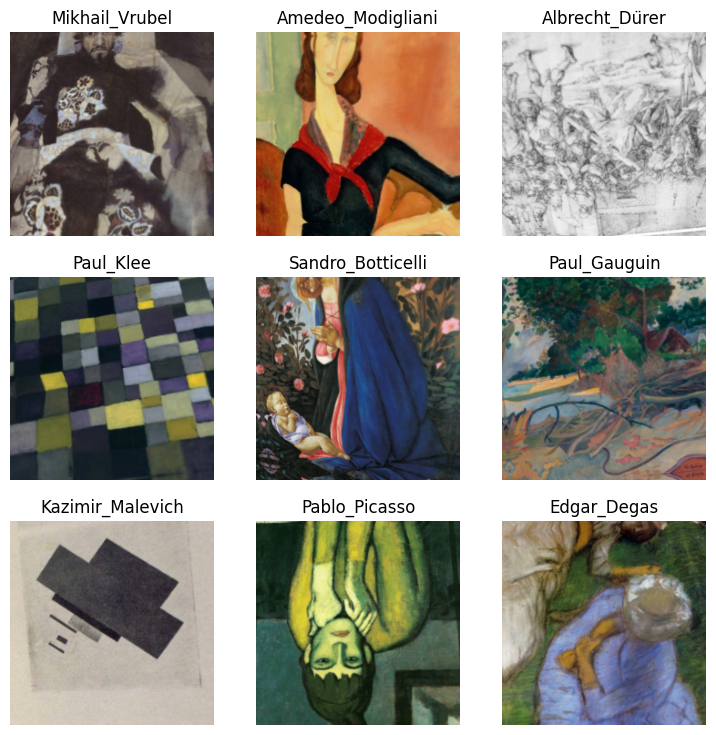

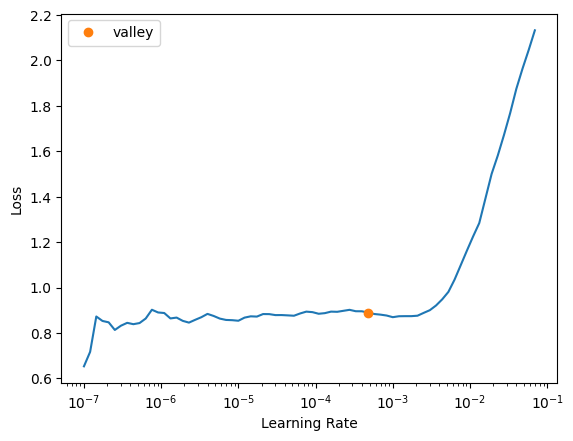

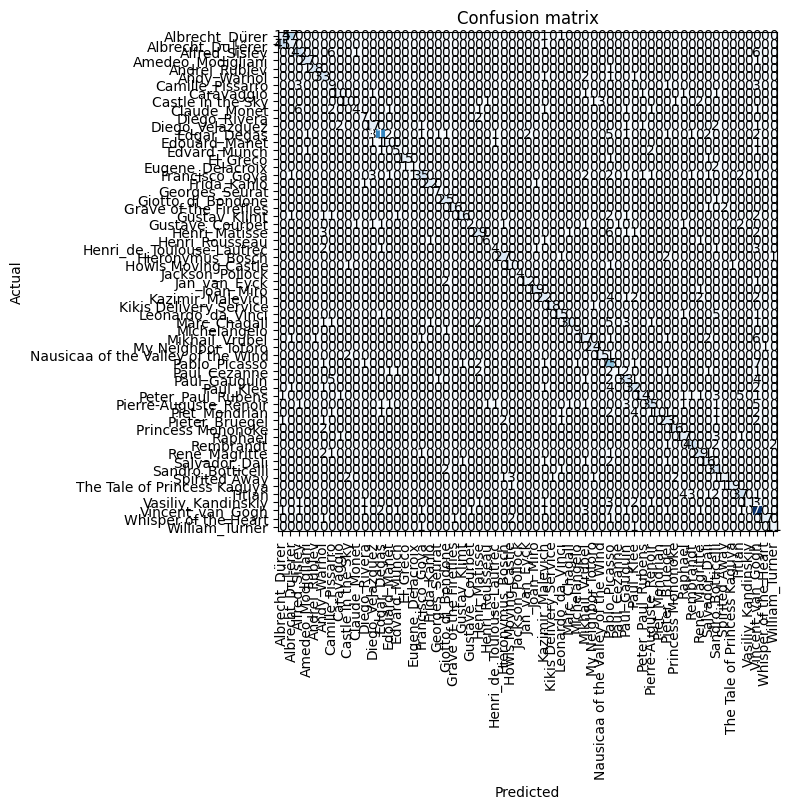

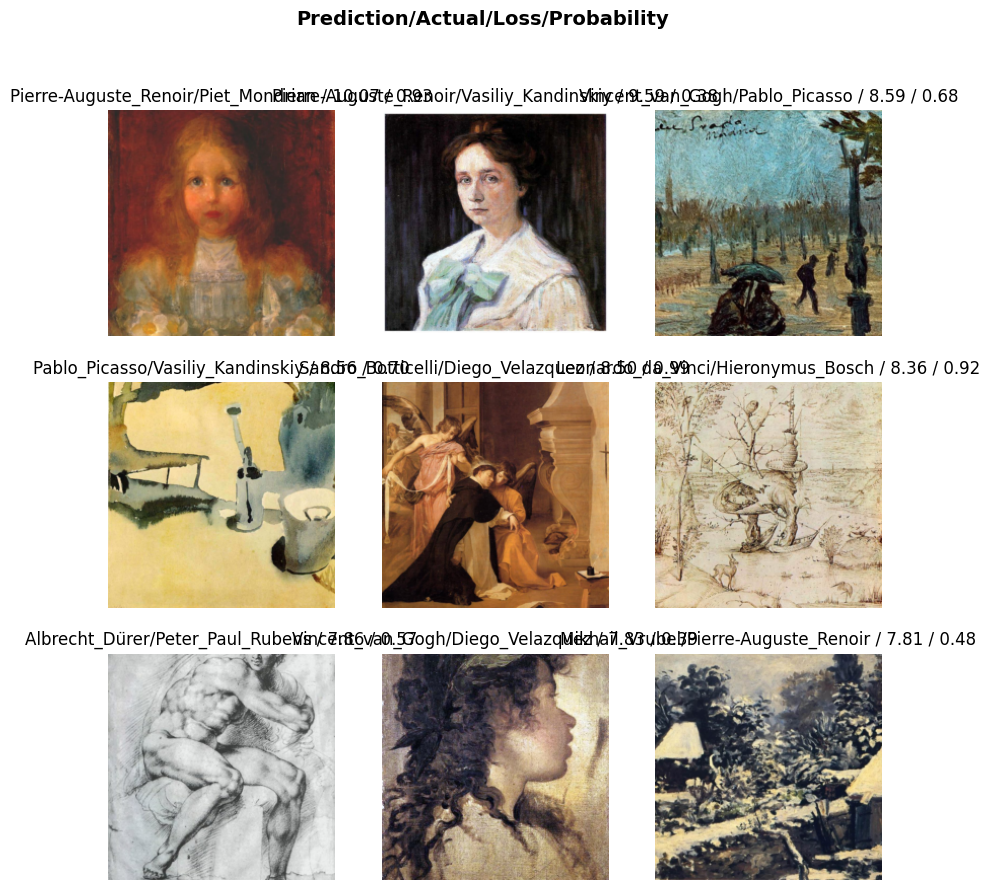

In [9]:
from fastai.vision.all import *
import matplotlib.pyplot as plt
from pathlib import Path

combined_dataset_path = Path("/kaggle/working/combined_dataset")

dls = ImageDataLoaders.from_folder(
    combined_dataset_path,
    valid_pct=0.2,        # 20% validation split
    seed=42,              # reproducibility
    item_tfms=Resize(224),
    batch_tfms=[*aug_transforms(flip_vert=True), Normalize.from_stats(*imagenet_stats)],
    bs=64                 # batch size
)

# Show a sample batch of images
dls.show_batch(max_n=9, figsize=(9, 9))

# Create learner with explicit model directory
model_path = Path("/kaggle/working")
learn = cnn_learner(dls, resnet50, metrics=[error_rate, accuracy], path=model_path)

# Initial training
learn.fine_tune(3)

# Fine-tune pretrained layers
learn.unfreeze()

# Find learning rate (optional but recommended)
learn.lr_find()

# Fine-tune more with gradual learning rate
learn.fit_one_cycle(13, lr_max=slice(1e-6, 1e-4))

# Export the trained model
learn.export(model_path/'style_classifier.pkl')

# Evaluate using interpretation
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)
interp.plot_top_losses(9, figsize=(10,10))

# Add prediction function for testing on new images
def predict_style(img_path):
    """Predict style (Artist, Ghibli, or Pixel Art) for a given image"""
    img = PILImage.create(img_path)
    
    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Test Image")
    plt.show()
    
    # Make prediction
    pred_class, pred_idx, probs = learn.predict(img)
    
    # Display results
    print(f"🎨 Predicted Style: {pred_class}")
    print(f"🔢 Confidence: {probs[pred_idx]:.2%}")
    
    # Show top 3 predictions
    top_preds = sorted(zip(learn.dls.vocab, map(float, probs)), key=lambda p: p[1], reverse=True)[:3]
    print("\nTop 3 predictions:")
    for style, prob in top_preds:
        print(f"{style}: {prob:.2%}")
    
    return pred_class, probs[pred_idx]

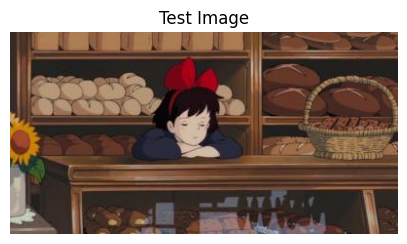

🎨 Predicted Style: Kikis Delivery Service
🔢 Confidence: 99.97%

Top 3 predictions:
Kikis Delivery Service: 99.97%
Whisper of the Heart: 0.02%
Castle in the Sky: 0.00%


('Kikis Delivery Service', tensor(0.9997))

In [18]:
predict_style("/kaggle/input/ghibli-movies-pictures/Ghibli_movie_dataset/Kikis Delivery Service/035df520-5d7b-4418-8f67-04177d6ced58.jpg")

📚 Found 2 main categories (excluding Pixel Art): ['Artist', 'Ghibli']

🧮 Number of images per main category:
 - Artist: 8774 images
 - Ghibli: 900 images


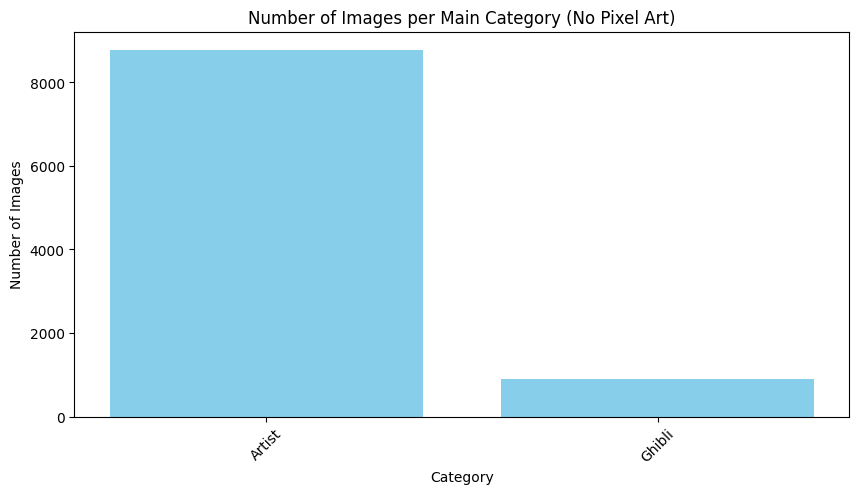


🎨 Showing random sample images:

🖼️ Category: Artist


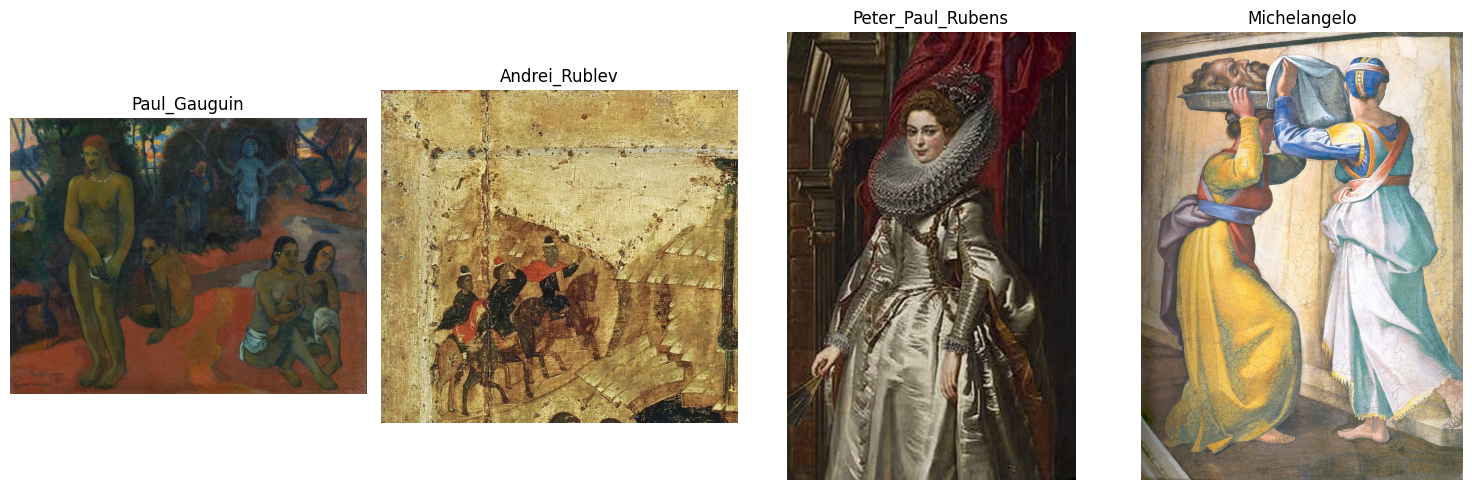


🖼️ Category: Ghibli


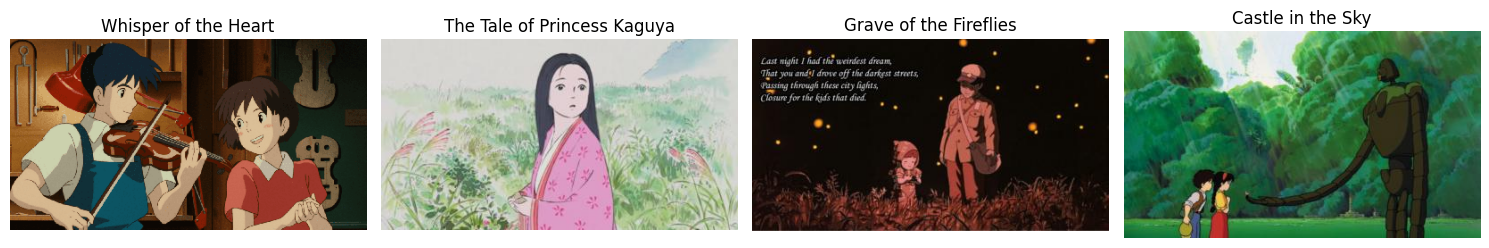

In [20]:
# 🚀 Dataset Exploration Block (Without Pixel Art)
from fastai.vision.all import *
import matplotlib.pyplot as plt
from collections import Counter
import random

# Set path to the merged dataset
combined_dataset_path = Path("/kaggle/working/combined_dataset")

# 1. List all classes (folders) and remove 'PixelArt' if exists
classes = [p.name for p in combined_dataset_path.ls() if p.is_dir()]
if 'PixelArt' in classes:
    classes.remove('PixelArt')

print(f"📚 Found {len(classes)} main categories (excluding Pixel Art): {classes}")

# 2. Count number of images per class
class_counts = {}
for class_folder in combined_dataset_path.iterdir():
    if class_folder.is_dir() and class_folder.name in classes:
        count = len(list(class_folder.rglob('*.jpg'))) + len(list(class_folder.rglob('*.png')))
        class_counts[class_folder.name] = count

# Display counts nicely
print("\n🧮 Number of images per main category:")
for cls, count in class_counts.items():
    print(f" - {cls}: {count} images")

# Optional: plot counts
plt.figure(figsize=(10,5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Number of Images per Main Category (No Pixel Art)')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# 3. Randomly show sample images from each class
def show_random_images(path, n_images=4):
    fig, axs = plt.subplots(1, n_images, figsize=(15, 5))
    img_paths = list(path.rglob('*.jpg')) + list(path.rglob('*.png'))
    if len(img_paths) == 0:
        print(f"No images found in {path}")
        return
    chosen_imgs = random.sample(img_paths, min(n_images, len(img_paths)))
    for ax, img_path in zip(axs, chosen_imgs):
        img = PILImage.create(img_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(img_path.parent.name)
    plt.tight_layout()
    plt.show()

print("\n🎨 Showing random sample images:")

# Show random images for each main class (only Artist and Ghibli)
for cls in classes:
    print(f"\n🖼️ Category: {cls}")
    show_random_images(combined_dataset_path/cls, n_images=4)
